## Goal

The goal of this analysis is to compare our PanPAM screening data to those generated by Neville Sanjana's group 

In [24]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from matplotlib import rc
warnings.filterwarnings('ignore')

import gpplot as gpp
# Set default settings for plotting
#sns.set_style('ticks')
#sns.set_context('talk')
#mpl.rc('pdf', fonttype=42)
#mpl.rcParams['font.sans-serif'] = "Arial"
#mpl.rcParams['font.family'] = "sans-serif"

In [25]:
#read in panpam
panpam = pd.read_table('../../data_v3/Fig 1_3_PanPAM on-target/processed/panpam_avglfc_v2.txt')

In [26]:
essential = panpam[panpam['Construct IDs'] == 'Essential']

In [27]:
essential['N_PAM'] = ['N'+p[1:3]+'N'  for p in essential['PAM']]

In [28]:
ng = essential[essential['N_PAM'].str.startswith('NG')]

This first plot is just comparing Cas9-NG and xCas9 in our PanPAM data.

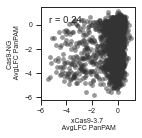

In [29]:
#compare activity with essential guides with Cas9-NG vs. xCas9-3.7 @ NG PAMs -- this is using only our data
gpp.set_aesthetics(context='paper')
fig, ax = plt.subplots(figsize=(1.7,1.7))
sns.scatterplot(y='A375_275_AVGLFC_frompDNA', x='A375_154_AVGLFC_frompDNA',
               data=ng, color=".2", linewidth=0, alpha=0.5)
gpp.add_correlation(data=ng, y='A375_275_AVGLFC_frompDNA', x='A375_154_AVGLFC_frompDNA')

plt.ylabel('Cas9-NG \n AvgLFC PanPAM', fontsize=7)
plt.xlabel('xCas9-3.7 \n AvgLFC PanPAM', fontsize=7)
plt.tick_params(axis='both', labelsize=7)
plt.xticks([-6,-4,-2,0])
plt.yticks([-6,-4,-2,0])
#plt.title('NG PAMs', fontsize=7)
plt.savefig('../../Figures/panels/Fig 3/xCas9_vs_NG.pdf', dpi=1000, bbox_inches='tight', transparent = True)



In [30]:
len(ng)

2747

In [31]:
#read in sanjana data
cd45 = pd.read_csv('../../Data_files/PAM_flex/Sanjana_comparison/Sanjana_ko_CD45_v2.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../Data_files/PAM_flex/Sanjana_comparison/Sanjana_ko_CD45_v2.csv'

In [ ]:
#Doesn't include the top bins, we'll exclude these data for now
#cd46 = pd.read_csv('sanjana_ko_CD46.csv')

In [ ]:
cd55 = pd.read_csv('../../Data_files/PAM_flex/Sanjana_comparison/Sanjana_ko_CD55.csv')

In [ ]:
#Concatenate the CD45 and CD55 data
sanjana = pd.concat([cd45, cd55])

In [ ]:
#Calculate LFC by subtracting the bottom bin from the top bin
sanjana['nuclease_Cas9_LFC'] = sanjana['nuclease_top_Cas9'] - sanjana['nuclease_bottom_Cas9']
sanjana['nuclease_xCas9_LFC'] = sanjana['nuclease_top_xCas9'] - sanjana ['nuclease_bottom_xCas9']
sanjana['nuclease_Cas9NG_LFC'] = sanjana['nuclease_top_Cas9NG'] - sanjana['nuclease_bottom_Cas9NG']

In [ ]:
sanjana.head()

In [ ]:
#Z-score based on the nontargeting controls
def get_z_score(data,col,control_category):
    mean = data.loc[data['regionName'].str.contains(control_category),col].mean()
    std = data.loc[data['regionName'].str.contains(control_category),col].std()
    data[str(col + ';z-score')] = data[col].apply(lambda x: (x-mean)/std)
    return data

In [ ]:
col = 'nuclease_Cas9_LFC'
get_z_score(sanjana, col, 'NonTargetingControlGuideForHuman')

In [ ]:
col = 'nuclease_xCas9_LFC'
get_z_score(sanjana, col, 'NonTargetingControlGuideForHuman')

In [ ]:
col = 'nuclease_Cas9NG_LFC'
get_z_score(sanjana, col, 'NonTargetingControlGuideForHuman')

In [ ]:
#Drop guides targeting the promoter for this analysis
sanjana = sanjana[~sanjana['regionName'].str.contains('promoter')]

In [ ]:
#sanjana.to_csv('../../Data_files/PAM_flex/Sanjana_comparison/2021-01-04_sanjana_comp.csv')

In [ ]:
#Drop guides targeting Nonessentials + BRCA from the panpam dataset
panpam = panpam[~panpam['Construct IDs'].str.contains('BRCA')]

In [ ]:
panpam = panpam[panpam['Construct IDs']!= 'NonEssential']

In [ ]:
panpam['Construct IDs'].value_counts()

In [ ]:
#Z-score based on the controls for panpam
def get_z_score(data,col,control_category):
    mean = data.loc[data['Construct IDs'].str.contains(control_category),col].mean()
    std = data.loc[data['Construct IDs'].str.contains(control_category),col].std()
    data[str(col + ';z-score')] = data[col].apply(lambda x: (x-mean)/std)
    return data

In [ ]:
col = 'A375_085_AVGLFC_frompDNA'
get_z_score(panpam, col, 'Control')

In [ ]:
col = 'A375_154_AVGLFC_frompDNA'
get_z_score(panpam, col, 'Control')

In [ ]:
col = 'A375_275_AVGLFC_frompDNA'
get_z_score(panpam, col, 'Control')

In [ ]:
panpam.to_csv('../../Data_files/PAM_flex/Sanjana_comparison/2021-05-11_zscored_panpam_v2.csv')

In [ ]:
pam_3nt = set(list(sanjana.PAM))

In [ ]:
#drop the control PAMs
pam_3nt.remove('TTTTTTT')

In [ ]:
#Calculate the median Z-score of each 3nt PAM for both datasets
columns = sanjana.columns
cond = list(columns[22:])

colnames = ['PAM']
pams = pam_3nt
colnames.extend(pams)
median_zscore_df = pd.DataFrame(columns=colnames)


for i,c in enumerate(cond):
    #print (c)
    row = [c]
    for i,p in enumerate(pams):
        #print(p)
        p_df = sanjana[sanjana['PAM'] == p]
        c_df = p_df.loc[:,[c]]
        #print (c_df)
        median_zscore = c_df.median()
        row.append(float(median_zscore))
        #print(row)
    median_zscore_df = median_zscore_df.append(pd.Series(row, index = colnames), ignore_index=True)

In [ ]:
median_zscore_df_sanjana = median_zscore_df

In [ ]:
median_zscore_df_sanjana.head()

In [ ]:
#transpose dfs to allow for smooth merge
median_zscore_df_sanjana_t = median_zscore_df_sanjana.T
median_zscore_df_sanjana_t.insert(0,'PAM',median_zscore_df_sanjana_t.index)
median_zscore_df_sanjana_t.index = list(range(0,len(median_zscore_df_sanjana_t)))
median_zscore_df_sanjana_t.columns = list(median_zscore_df_sanjana_t.iloc[0,:])
median_zscore_df_sanjana_t = median_zscore_df_sanjana_t.drop(0)
median_zscore_df_sanjana_t.head()

In [ ]:
median_zscore_df_sanjana_t.to_csv('../../Data_files/PAM_flex/Sanjana_comparison/Sanjana_median_zscore_v2.csv')

In [ ]:
panpam['3 nuc PAM'] = [p[0:3]  for p in panpam.PAM]

In [ ]:
cond = ['A375_085_AVGLFC_frompDNA;z-score',
       'A375_154_AVGLFC_frompDNA;z-score',
       'A375_275_AVGLFC_frompDNA;z-score']

In [ ]:
#Calculate the median Z-score of each 3nt PAM for PanPAM

colnames = ['PAM']
pams = pam_3nt
colnames.extend(pams)
median_zscore_df = pd.DataFrame(columns=colnames)

for c in cond:
    #print (c)
    row = [c]
    for i,p in enumerate(pams):
        #print(p)
        p_df = panpam[panpam['3 nuc PAM'] == p]
        c_df = p_df.loc[:,[c]]
        #print (c_df)
        median_zscore = c_df.median()
        row.append(float(median_zscore))
        #print(row)
    median_zscore_df = median_zscore_df.append(pd.Series(row, index = colnames), ignore_index=True)

In [ ]:
panpam_median_zscore_df = median_zscore_df

In [ ]:
#transpose dfs to allow for smooth merge
panpam_median_zscore_df_t = panpam_median_zscore_df.T
panpam_median_zscore_df_t.insert(0,'PAM',panpam_median_zscore_df_t.index)
panpam_median_zscore_df_t.index = list(range(0,len(panpam_median_zscore_df_t)))
panpam_median_zscore_df_t.columns = list(panpam_median_zscore_df_t.iloc[0,:])
panpam_median_zscore_df_t = panpam_median_zscore_df_t.drop(0)
panpam_median_zscore_df_t.head()

In [ ]:
panpam_median_zscore_df_t.to_csv('../../Data_files/PAM_flex/Sanjana_comparison/PanPAM_median_zscore_v2.csv')

In [ ]:
#merge median z-scores for the 2 data sets to make comparisons
sanjana_panpam = pd.merge(median_zscore_df_sanjana_t, panpam_median_zscore_df_t, on = 'PAM')

In [ ]:
sanjana_panpam['N_PAM'] = ['N' + p[1:3] for p in sanjana_panpam.PAM]

In [37]:
#sanjana_panpam.to_csv('../../data_v3/Fig 1_3_PanPAM on-target/external/Sanjana_comparison/PanPAM_Sanjana_combined_median_zscore_v2.csv')

NameError: name 'sanjana_panpam' is not defined

## Plots start here 

In [38]:
#read in this merged file, rather than rerunning all of the above code, when just interested in making plots

sanjana_panpam = pd.read_csv('../../data_v3/Fig 1_3_PanPAM on-target/external/Sanjana_comparison/PanPAM_Sanjana_combined_median_zscore_v2.csv')

In [39]:
#filter for ng pams
sanjana_panpam_ng = sanjana_panpam[sanjana_panpam['N_PAM'].str.startswith('NG')]

In [40]:
gpp.set_aesthetics(context='paper', palette='Set2')

<AxesSubplot:title={'center':'WTCas9'}, xlabel='Legut et al \n Z-scored LFC', ylabel='PanPAM \n Z-scored LFC'>

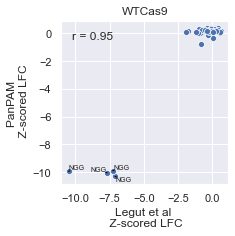

In [44]:
#look @ all PAMs for WT Cas9
ax = sns.scatterplot(x = 'nuclease_Cas9_LFC;z-score', y = 'A375_085_AVGLFC_frompDNA;z-score',
               data = sanjana_panpam)
sns.set(rc={'figure.figsize':(3,3)})
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_Cas9_LFC;z-score', y = 'A375_085_AVGLFC_frompDNA;z-score')
#ax.text(0.98,0,'r = '+str(corr), fontsize=18,ha='right',va='bottom',transform=ax.transAxes)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Legut et al \n Z-scored LFC')
plt.ylabel('PanPAM \n Z-scored LFC')
plt.title ('WTCas9')


label = ['NGG']
gpp.label_points(sanjana_panpam,'nuclease_Cas9_LFC;z-score', 'A375_085_AVGLFC_frompDNA;z-score', label, 'N_PAM', size = 7)


#plt.savefig('Sanjana_Panpam_WT.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [ ]:
#NG PAMs between 2 studies
ax = sns.scatterplot(x = 'nuclease_Cas9NG_LFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam_ng, hue = 'N_PAM')
sns.set(rc={'figure.figsize':(3,3)})
gpp.add_correlation(data=sanjana_panpam_ng, x = 'nuclease_Cas9NG_LFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score')
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Legut et al \n Z-scored LFC')
plt.ylabel('PanPAM \n Z-scored LFC')
plt.title ('Cas9-NG \n NG PAMs')
#plt.savefig('Sanjana_Panpam_Cas9NG_ngPAMs.pdf', dpi=1000, bbox_inches='tight')

In [45]:
pam_type = []
for i in sanjana_panpam.N_PAM:
    pam = ''
    if i == 'NGG':
        pam = i
    elif i == 'NGA':
        pam = i
    elif i == 'NGC':
        pam = i
    elif i == 'NGT':
        pam = i
    else:
        pam = 'other'
    pam_type.append(pam)

In [46]:
sanjana_panpam['n_pam_hue'] = pam_type

In [47]:
color_dictionary = dict({'NGG':'#fc8d62',
                  'NGA':'#e78ac3',
                  'NGT': '#a6d854',
                  'NGC': '#8da0cb',
                  'other' : '#66c2a5'})

Text(0.5, 1.0, 'Cas9-NG')

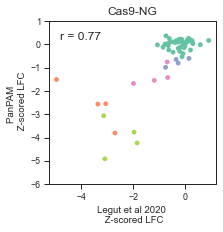

In [53]:
#all NG PAMs
gpp.set_aesthetics(context='paper')
ax = sns.scatterplot(x = 'nuclease_Cas9NG_LFC;z-score', y = 'A375_275_AVGLFC_frompDNA;z-score',
               data = sanjana_panpam, hue = 'n_pam_hue', linewidth=0., palette=color_dictionary, legend=False)
sns.set(rc={'figure.figsize':(3,3)})
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_Cas9NG_LFC;z-score', y = 'A375_275_AVGLFC_frompDNA;z-score')
plt.ylim(-6,1)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Legut et al 2020 \n Z-scored LFC')
plt.ylabel('PanPAM \n Z-scored LFC')
plt.title ('Cas9-NG')
#plt.savefig('../../Figures/panels/Fig 3/Sanjana_Panpam_Cas9NG_v2.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [61]:
gpp.set_aesthetics(context='paper')

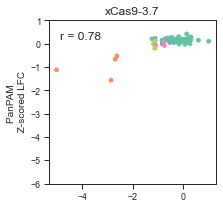

In [62]:

ax = sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'A375_154_AVGLFC_frompDNA;z-score',
               data = sanjana_panpam, hue = 'n_pam_hue', linewidth=0., palette=color_dictionary,legend=False)
sns.set(rc={'figure.figsize':(3,3)})
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_xCas9_LFC;z-score', y = 'A375_154_AVGLFC_frompDNA;z-score')
plt.ylim(-6,1)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('')
plt.ylabel('PanPAM \n Z-scored LFC', fontsize=10)
plt.title ('xCas9-3.7')
plt.savefig('../../Figures/panels/Fig 3/Sanjana_Panpam_xCas9-3.7.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [ ]:
#all 64 PAMs between enzymes
ax = sns.scatterplot(x = 'nuclease_Cas9NG_LFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam)
sns.set(rc={'figure.figsize':(3,3)})
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_Cas9NG_LFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score')
plt.ylim(-6,1)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Legut et al \n Z-scored LFC')
plt.ylabel('PanPAM \n Z-scored LFC')
plt.title ('Cas9-NG \n all PAMs')
#plt.savefig('Sanjana_Panpam_Cas9NG_ngPAMs.pdf', dpi=1000, bbox_inches='tight')

In [ ]:
ax = sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam_ng, hue = 'N_PAM')
gpp.add_correlation(data=sanjana_panpam_ng, x = 'nuclease_xCas9_LFC;z-score', y = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score')

ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Legut et al \n Z-scored LFC')
plt.ylabel('PanPAM \n Z-scored LFC')
plt.title ('xCas9 \n NG PAMs')
#plt.savefig('Sanjana_Panpam_xCas9_ngPAMs.pdf', dpi=1000, bbox_inches='tight')


In [ ]:
#xCas9 all PAMs
ax = sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam)
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_xCas9_LFC;z-score', y = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score')

#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Legut et al \n Z-scored LFC')
plt.ylabel('PanPAM \n Z-scored LFC')
plt.title ('xCas9 \n all PAMs')
#plt.savefig('Sanjana_Panpam_xCas9_ngPAMs.pdf', dpi=1000, bbox_inches='tight')


In [ ]:
#compare xCas9 and WT Cas9 in Sanjana's data
ax = sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9_LFC;z-score',
               data = sanjana_panpam)
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9_LFC;z-score')
label = ['NGG']
gpp.label_points(sanjana_panpam,'nuclease_xCas9_LFC;z-score', 'nuclease_Cas9_LFC;z-score', label, 'N_PAM', size = 7)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sanjana \n xCas9 vs. WTCas9')


In [ ]:
#compare xCas9 and WTCas9 in PanPAM data
ax = sns.scatterplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam)
gpp.add_correlation(data=sanjana_panpam, x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score')
label = ['NGG']
gpp.label_points(sanjana_panpam,'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score', label, 'N_PAM', size = 7)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PanPAM \n xCas9 vs. WTCas9')



In [ ]:
ax = sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9NG_LFC;z-score',
               data = sanjana_panpam, hue='n_pam_hue')
gpp.add_correlation(data=sanjana_panpam, x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9NG_LFC;z-score')
#label = ['NGG', 'NGA', 'NGC', 'NGT']
#gpp.label_points(sanjana_panpam,'nuclease_xCas9_LFC;z-score', 'nuclease_Cas9NG_LFC;z-score', 'N_PAM', size = 7)
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sanjana xCas9 vs. Cas9-NG \n All PAMs')

In [ ]:
ax = sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9NG_LFC;z-score',
               data = sanjana_panpam_ng, hue='N_PAM')
gpp.add_correlation(data=sanjana_panpam_ng, x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9NG_LFC;z-score')
#label = ['NGG', 'NGA' 'NGC', 'NGT']
#gpp.label_points(sanjana_panpam,'nuclease_xCas9_LFC;z-score', 'nuclease_Cas9NG_LFC;z-score', label, 'N_PAM', size = 7)
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Sanjana xCas9 vs. Cas9-NG \n ng PAMs')

In [ ]:
ax = sns.scatterplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam)
gpp.add_correlation(data=sanjana_panpam, x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score')
label = ['NGG', 'NGA', 'NGC', 'NGT']
gpp.label_points(sanjana_panpam,'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score', label, 'N_PAM', size = 7)
#ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PanPAM xCas9 vs. NG \n all PAMs')


In [ ]:
ax = sns.scatterplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score',
               data = sanjana_panpam_ng, hue='N_PAM')
gpp.add_correlation(data=sanjana_panpam_ng, x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score')
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PanPAM xCas9 vs. NG \n NG PAMs')


## Compare xCas9 to Cas9-NG between datasets

### Sanjana 

In [32]:
sanjana = pd.read_csv('../../data_v3/Fig 1_3_PanPAM on-target/external/Sanjana_comparison/2021-01-05_sanjana_comp.csv')

In [ ]:
gpp.set_aesthetics(context='paper', palette='Set2')
sns.scatterplot(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9NG_LFC;z-score', data= sanjana, color=".2", linewidth=0.1)
gpp.add_correlation(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9NG_LFC;z-score', data= sanjana)
plt.title('Sanjana all sgRNA \n xCas9 vs. NG')
print(len(sanjana))


In [33]:
sanjana_ng = sanjana[sanjana['PAM'].str.endswith('GG')]

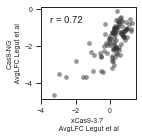

In [35]:
gpp.set_aesthetics(context='paper')
fig, ax = plt.subplots(figsize=(1.7,1.7))

sns.scatterplot(x = 'nuclease_xCas9_LFC', y = 'nuclease_Cas9NG_LFC', data= sanjana_ng, color=".2", linewidth=0., alpha=0.5)
gpp.add_correlation(x = 'nuclease_xCas9_LFC', y = 'nuclease_Cas9NG_LFC', data= sanjana_ng)

plt.ylabel('Cas9-NG \n AvgLFC Legut et al', fontsize=7)
plt.xlabel('xCas9-3.7 \n AvgLFC Legut et al', fontsize=7)
#plt.title('Sanjana ng PAMs \n xCas9 vs. NG')
plt.tick_params(axis='both', labelsize=7)
plt.xticks([-4, -2, 0])
plt.yticks([-4, -2, 0])
plt.savefig('../../Figures/panels/Fig 3/Sanjana_NGvsxCas9.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [29]:
print(len(sanjana_ng))

108


<AxesSubplot:xlabel='nuclease_xCas9_LFC', ylabel='nuclease_Cas9_LFC'>

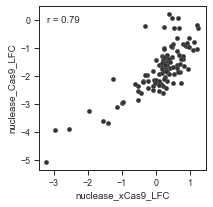

In [93]:
gpp.set_aesthetics(context='paper', palette='Set2')

sns.scatterplot(x = 'nuclease_xCas9_LFC', y = 'nuclease_Cas9_LFC', data= sanjana_ng, color=".2", linewidth=0.1)
gpp.add_correlation(x = 'nuclease_xCas9_LFC', y = 'nuclease_Cas9_LFC', data= sanjana_ng)
#plt.title('Sanjana ng PAMs \n xCas9 vs. NG')
#plt.savefig('../../Figures/panels/Sanjana_NGvsxCas9.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [92]:
print(len(sanjana_ng))

108


Text(0.5, 1.0, 'Sanjana all sgRNA \n xCas9 vs. WT')

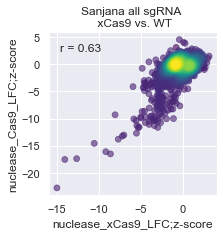

In [64]:
gpp.point_densityplot(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9_LFC;z-score', data= sanjana)
gpp.add_correlation(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9_LFC;z-score', data= sanjana)
plt.title('Sanjana all sgRNA \n xCas9 vs. WT')


Text(0.5, 1.0, 'Sanjana ng PAMs \n xCas9 vs. WT')

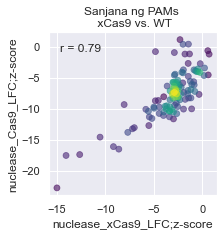

In [65]:
gpp.point_densityplot(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9_LFC;z-score', data= sanjana_ng)
gpp.add_correlation(x = 'nuclease_xCas9_LFC;z-score', y = 'nuclease_Cas9_LFC;z-score', data= sanjana_ng)
plt.title('Sanjana ng PAMs \n xCas9 vs. WT')

## PanPAM 

In [66]:
panpam = pd.read_csv('../../Data_files/PAM_flex/Sanjana_comparison/2021-01-14_zscored_panpam.csv')

Text(0.5, 1.0, 'PanPAM all sgRNA \n xCas9 vs. NG')

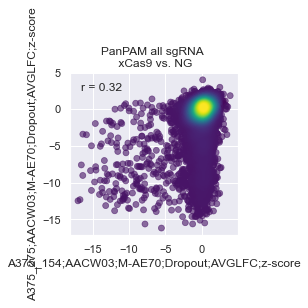

In [67]:
gpp.point_densityplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam)
gpp.add_correlation(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam)
plt.title('PanPAM all sgRNA \n xCas9 vs. NG')

In [68]:
panpam_ng = panpam[panpam['N_PAM'].str.startswith('NG')]

Text(0.5, 1.0, 'PanPAM NG PAMs \n xCas9 vs. NG')

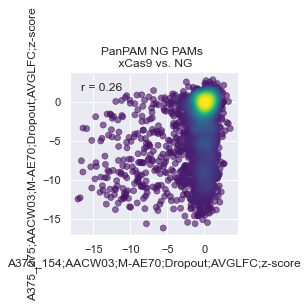

In [69]:
gpp.point_densityplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam_ng)
gpp.add_correlation(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_275;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam_ng)
plt.title('PanPAM NG PAMs \n xCas9 vs. NG')

Text(0.5, 1.0, 'PanPAM all sgRNA \n xCas9 vs. WT')

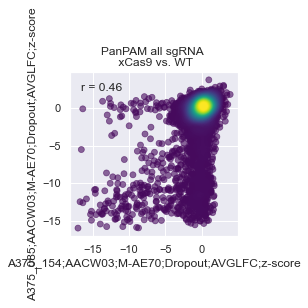

In [70]:
gpp.point_densityplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam)
gpp.add_correlation(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam)
plt.title('PanPAM all sgRNA \n xCas9 vs. WT')


Text(0.5, 1.0, 'PanPAM NG PAM \n xCas9 vs. WT')

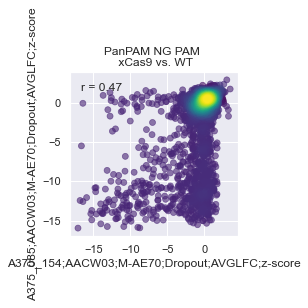

In [71]:
gpp.point_densityplot(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam_ng)
gpp.add_correlation(x = 'A375_154;AACW03;M-AE70;Dropout;AVGLFC;z-score', y = 'A375_085;AACW03;M-AE70;Dropout;AVGLFC;z-score', data= panpam_ng)
plt.title('PanPAM NG PAM \n xCas9 vs. WT')